In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

# Data loading

Dataset diambil dari [Kaggle Gold Price Prediction Dataset](https://www.kaggle.com/sid321axn/gold-price-prediction-dataset). Dataset tersebut dikumpulkan dari 18 November 2011 hingga 1 Januari 2019 yang berisi 1718 baris dan 80 kolom.

Target class dari dataset ini adalah Adjusted Close yang merupakan harga Close yang disesuaikan dengan faktor seperti dividen, pemecahan saham, dan penawaran saham baru untuk menentukan nilai.

In [22]:
csv = "FINAL_USO.csv"
gold_df = pd.read_csv(csv)
X = gold_df.copy()
y = X.pop('Adj Close')
date = X.pop('Date')
X.pop('Close')
X.head()

,Open,High,Low,Volume,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,SP_volume,DJ_open,DJ_high,DJ_low,DJ_close,DJ_Ajclose,DJ_volume,EG_open,EG_high,EG_low,EG_close,EG_Ajclose,EG_volume,EU_Price,EU_open,EU_high,EU_low,EU_Trend,OF_Price,OF_Open,OF_High,OF_Low,OF_Volume,OF_Trend,OS_Price,OS_Open,OS_High,OS_Low,OS_Trend,SF_Price,SF_Open,SF_High,SF_Low,SF_Volume,SF_Trend,USB_Price,USB_Open,USB_High,USB_Low,USB_Trend,PLT_Price,PLT_Open,PLT_High,PLT_Low,PLT_Trend,PLD_Price,PLD_Open,PLD_High,PLD_Low,PLD_Trend,RHO_PRICE,USDI_Price,USDI_Open,USDI_High,USDI_Low,USDI_Volume,USDI_Trend,GDX_Open,GDX_High,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,154.740005,154.949997,151.710007,21521900,123.029999,123.199997,121.989998,122.180000,105.441238,199109200,11825.29004,11967.83984,11825.21973,11868.80957,11868.80957,136930000,74.550003,76.150002,72.150002,72.900002,70.431755,787900,1.3018,1.2982,1.3051,1.2957,1,105.09,104.88,106.50,104.88,14330,1,93.42,94.91,96.00,93.33,0,53604,54248,54248,52316,119440,1,1.911,1.911,1.911,1.911,1,1414.65,1420.30,1423.35,1376.85,0,618.85,614.70,615.00,614.60,1,1425,80.341,80.565,80.630,80.130,22850,0,53.009998,53.139999,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,154.309998,155.369995,153.899994,18124300,122.230003,122.949997,121.300003,121.589996,105.597549,220481400,11870.25000,11968.17969,11819.30957,11866.38965,11866.38965,389520000,73.599998,75.099998,73.349998,74.900002,72.364037,896600,1.3035,1.3020,1.3087,1.2997,1,103.35,103.51,104.56,102.46,140080,0,93.79,93.43,94.80,92.53,1,53458,53650,54030,52890,65390,0,1.851,1.851,1.851,1.851,0,1420.25,1414.75,1431.75,1400.70,1,623.65,622.60,623.45,622.30,1,1400,80.249,80.175,80.395,79.935,13150,0,52.500000,53.180000,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,155.479996,155.860001,154.360001,12547200,122.059998,122.320000,120.029999,120.290001,104.468536,183903000,11866.54004,11925.87988,11735.19043,11766.25977,11766.25977,135170000,69.099998,69.800003,64.199997,64.699997,62.509384,2096700,1.2995,1.3043,1.3044,1.2981,0,103.64,103.63,104.57,102.37,147880,1,94.09,93.77,94.43,92.55,1,52961,53400,53400,52544,67280,0,1.810,1.810,1.810,1.810,0,1411.10,1422.65,1427.60,1404.60,0,608.80,626.00,630.00,608.60,0,1400,80.207,80.300,80.470,80.125,970,0,52.490002,52.549999,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,156.820007,157.429993,156.580002,9136300,122.180000,124.139999,120.370003,123.930000,107.629784,225418100,11769.20996,12117.12988,11768.83008,12103.58008,12103.58008,165180000,66.449997,68.099998,66.000000,67.000000,64.731514,875300,1.3079,1.3003,1.3133,1.2994,1,106.73,104.30,107.27,103.91,170240,1,95.55,96.39,99.70,96.39,1,53487,52795,53575,52595,55130,1,1.927,1.927,1.927,1.927,1,1434.75,1408.95,1436.55,1408.15,1,626.65,622.45,622.45,622.45,1,1400,80.273,80.890,80.940,80.035,22950,1,52.380001,53.250000,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,156.979996,157.529999,156.130005,11996100,123.930000,124.360001,122.750000,124.169998,107.838242,194230900,12103.58008,12119.70020,11999.44043,12107.74023,12107.74023,163250000,67.099998,69.400002,66.900002,68.500000,66.180725,837600,1.3045,1.3079,1.3197,1.3024,0,107.71,107.15,108.17,106.16,145090,1,99.01,97.54,99.26,96.81,1,53148,53519,54184,52937,75950,0,1.970,1.970,1.970,1.970,1,1429.05,1434.40,1453.75,1417.65,0,635.90,625.70,641.50,623.80,1,1400,80.350,80.105,80.445,79.550,24140,1,53.150002,53.430000,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


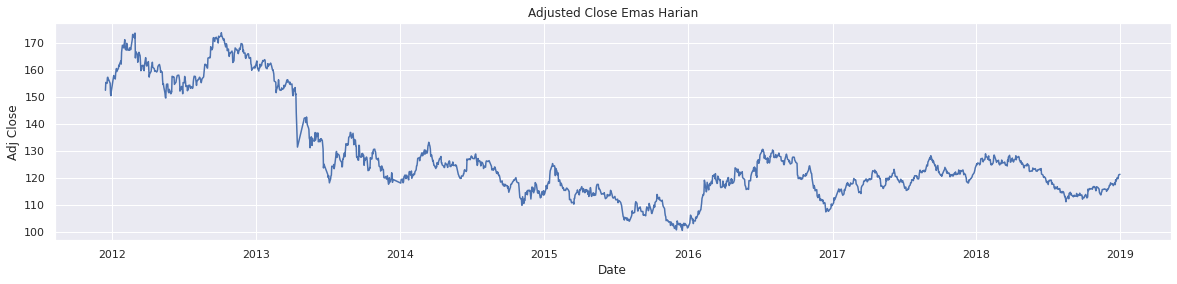

In [23]:
gold_df['Date'] = pd.to_datetime(gold_df['Date'], format = '%Y-%m-%d')

# Adjusted Close with Time Series
sns.set(rc={"figure.figsize":(20, 4)})
daily_change = sns.lineplot(x="Date", y="Adj Close", 
                            data=gold_df).set(title="Adjusted Close Emas Harian")

# Exploratory Data Analysis

Cek jumlah kolom dan baris dari dataset

In [24]:
row, col = X.shape
print('{} rows, {} features'.format(row, col))

1718 rows, 78 features


## Deskripsi variabel

Cek informasi karakteristik dari tiap kolom

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1718 non-null   float64
 1   High           1718 non-null   float64
 2   Low            1718 non-null   float64
 3   Volume         1718 non-null   int64  
 4   SP_open        1718 non-null   float64
 5   SP_high        1718 non-null   float64
 6   SP_low         1718 non-null   float64
 7   SP_close       1718 non-null   float64
 8   SP_Ajclose     1718 non-null   float64
 9   SP_volume      1718 non-null   int64  
 10  DJ_open        1718 non-null   float64
 11  DJ_high        1718 non-null   float64
 12  DJ_low         1718 non-null   float64
 13  DJ_close       1718 non-null   float64
 14  DJ_Ajclose     1718 non-null   float64
 15  DJ_volume      1718 non-null   int64  
 16  EG_open        1718 non-null   float64
 17  EG_high        1718 non-null   float64
 18  EG_low  

Cek bagaimana distribusi variabel dalam dataset

In [26]:
X.describe()

,Open,High,Low,Volume,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,SP_volume,DJ_open,DJ_high,DJ_low,DJ_close,DJ_Ajclose,DJ_volume,EG_open,EG_high,EG_low,EG_close,EG_Ajclose,EG_volume,EU_Price,EU_open,EU_high,EU_low,EU_Trend,OF_Price,OF_Open,OF_High,OF_Low,OF_Volume,OF_Trend,OS_Price,OS_Open,OS_High,OS_Low,OS_Trend,SF_Price,SF_Open,SF_High,SF_Low,SF_Volume,SF_Trend,USB_Price,USB_Open,USB_High,USB_Low,USB_Trend,PLT_Price,PLT_Open,PLT_High,PLT_Low,PLT_Trend,PLD_Price,PLD_Open,PLD_High,PLD_Low,PLD_Trend,RHO_PRICE,USDI_Price,USDI_Open,USDI_High,USDI_Low,USDI_Volume,USDI_Trend,GDX_Open,GDX_High,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
count,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03
mean,127.323434,127.854237,126.777695,8.446327e+06,204.490023,205.372637,203.487014,204.491222,192.204570,1.098026e+08,18161.094398,18244.137842,18073.889095,18164.119043,18164.119043,1.779131e+08,28.276554,28.822555,27.653655,28.209302,27.783958,1.136074e+06,1.208494,1.208531,1.213360,1.203692,0.494761,77.504523,77.521740,78.384936,76.593894,225958.585565,0.498836,70.153097,70.275396,71.120256,69.330990,0.503492,43284.478463,43308.692084,43671.194412,42911.912107,26912.462165,0.480792,2.262769,2.263091,2.286512,2.238765,0.490105,1183.915425,1184.388853,1194.274622,1173.409692,0.484284,766.805122,766.363481,773.529302,759.444208,0.530850,1130.442375,89.809427,89.805442,90.098981,89.509331,27568.300349,0.512806,26.747427,27.071304,26.384575,26.715012,25.924624,4.356515e+07,22.113417,22.307148,21.904657,22.109051,22.109051,1.922313e+07
std,17.526993,17.631189,17.396513,4.920731e+06,43.831928,43.974644,43.618940,43.776999,48.514161,4.925110e+07,3889.752079,3906.008604,3867.959072,3884.495887,3884.495887,1.212753e+08,20.325861,20.620624,19.972314,20.294635,19.721857,7.301289e+05,0.100535,0.100579,0.100184,0.100695,0.500118,27.400703,27.366113,27.393294,27.322868,88844.540581,0.500144,23.471514,23.480047,23.494737,23.422198,0.500133,7530.704012,7550.423242,7614.302267,7443.076538,21880.969122,0.499776,0.433469,0.433977,0.437574,0.429960,0.500048,273.842095,273.978168,275.427791,271.799909,0.499898,148.307189,148.078365,149.010291,147.381087,0.499193,570.012881,7.516115,7.520788,7.567895,7.459269,14643.314699,0.499982,10.620552,10.706388,10.490908,10.603110,9.886570,2.909151e+07,11.431056,11.478671,11.373997,11.432787,11.432787,1.575743e+07
min,100.919998,100.989998,100.230003,1.501600e+06,122.059998,122.320000,120.029999,120.290001,104.468536,2.785650e+07,11769.209960,11925.879880,11735.190430,11766.259770,11766.259770,8.410000e+06,2.770000,2.850000,2.730000,2.800000,2.800000,1.645000e+05,1.038700,1.039000,1.041900,1.034100,0.000000,27.880000,27.990000,28.750000,27.100000,11520.000000,0.000000,26.550000,27.340000,27.610000,26.180000,0.000000,33170.000000,33146.000000,33566.000000,32626.000000,40.000000,0.000000,1.358000,1.366000,1.391000,1.321000,0.000000,775.600000,765.300000,786.500000,756.000000,0.000000,470.450000,458.600000,473.150000,458.600000,0.000000,0.000000,78.300000,78.220000,78.640000,78.120000,60.000000,

## Menganani missing value

Cek apakah terdapat missing value di dalam data. Karena data sudah cukup bersih, maka tidak perlu melakukan proses handling missing value

In [27]:
# check null value
print('Null value:', X.isnull().any().sum())

Null value: 0


## Univariate analysis

Analisa histogram dari tiap fitur

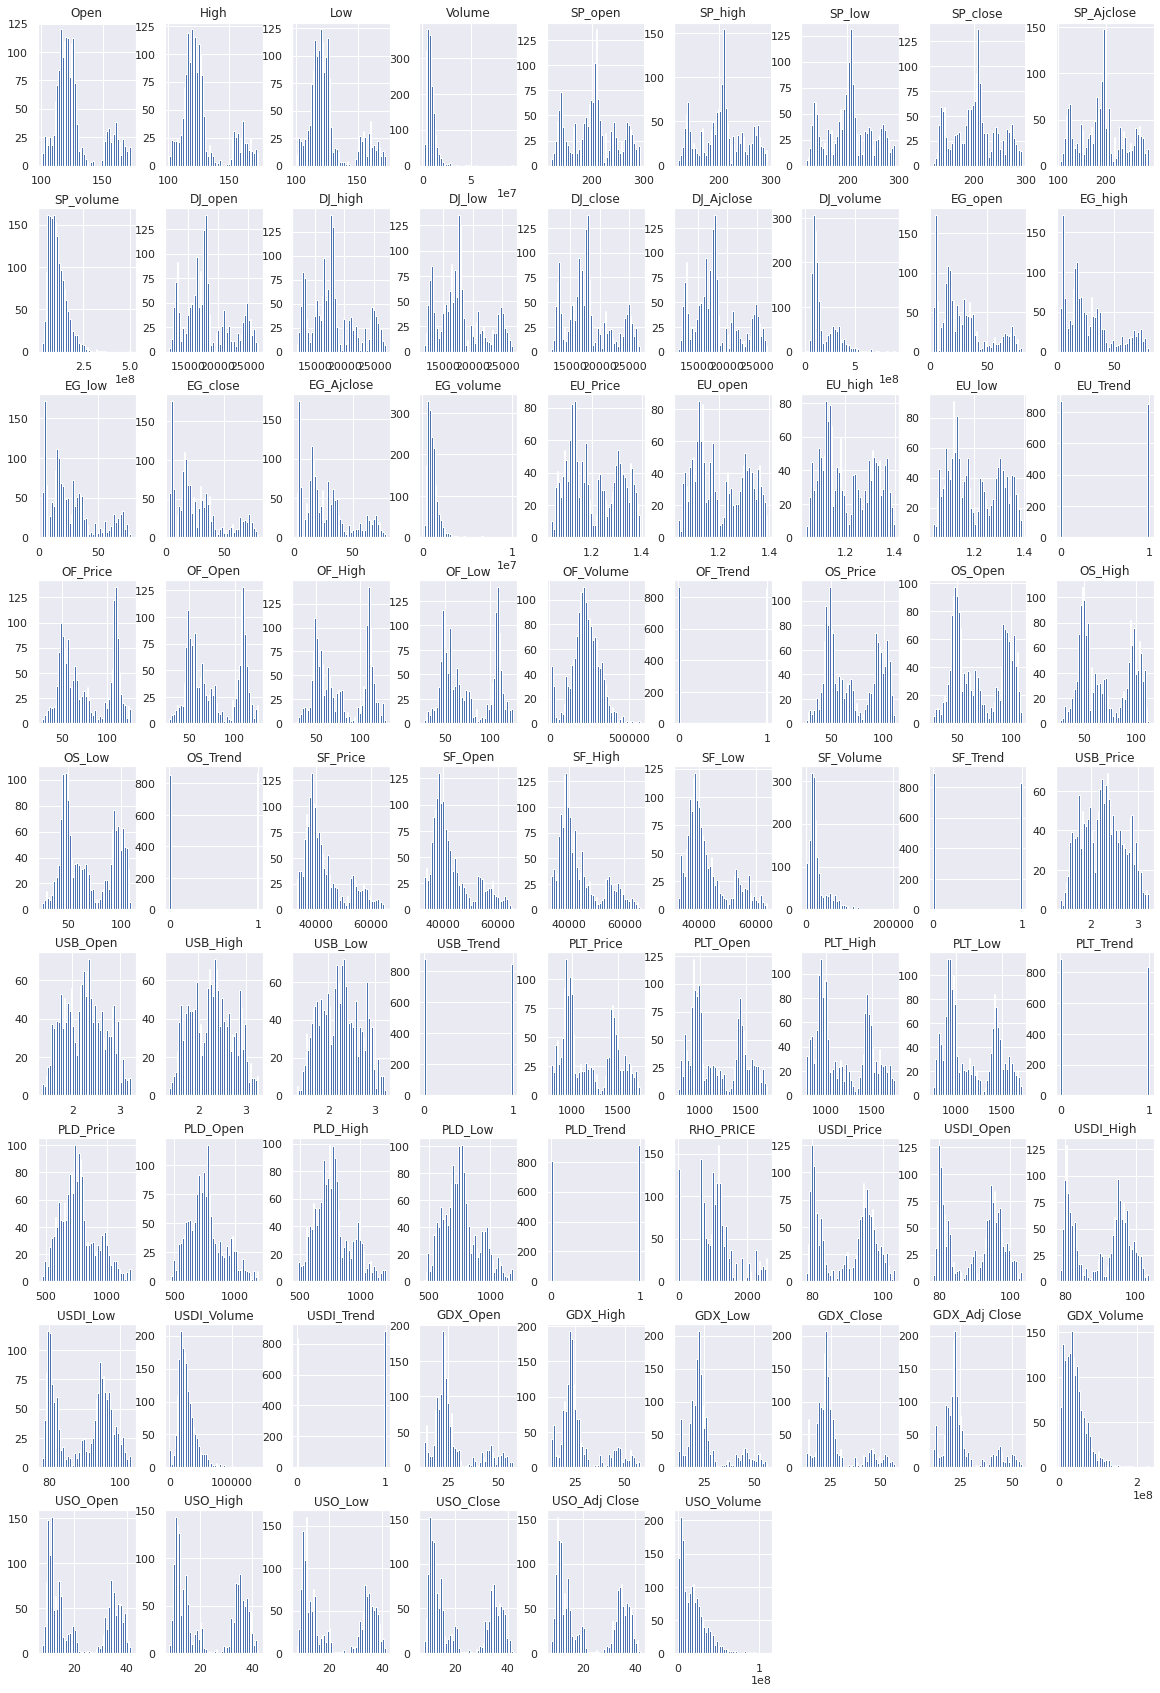

In [28]:
X.hist(bins=50, figsize=(20,30))
plt.show()

## Multivariate analysis

analisa hubungan korelasi antar fitur pada data. koefisien korelasi berkisar antara -1 dan +1. Ia mengukur kekuatan hubungan antara dua variabel serta arahnya (positif atau negatif). Mengenai kekuatan hubungan antar variabel, semakin dekat nilainya ke 1 atau -1, korelasinya semakin kuat. Sedangkan, semakin dekat nilainya ke 0, korelasinya semakin lemah.

sehingga dapat disimpulkan terdapat beberapa fitur redundant (tidak berguna) pada dataset

Text(0.5, 1.0, 'Correlation Matrix pada Fitur')

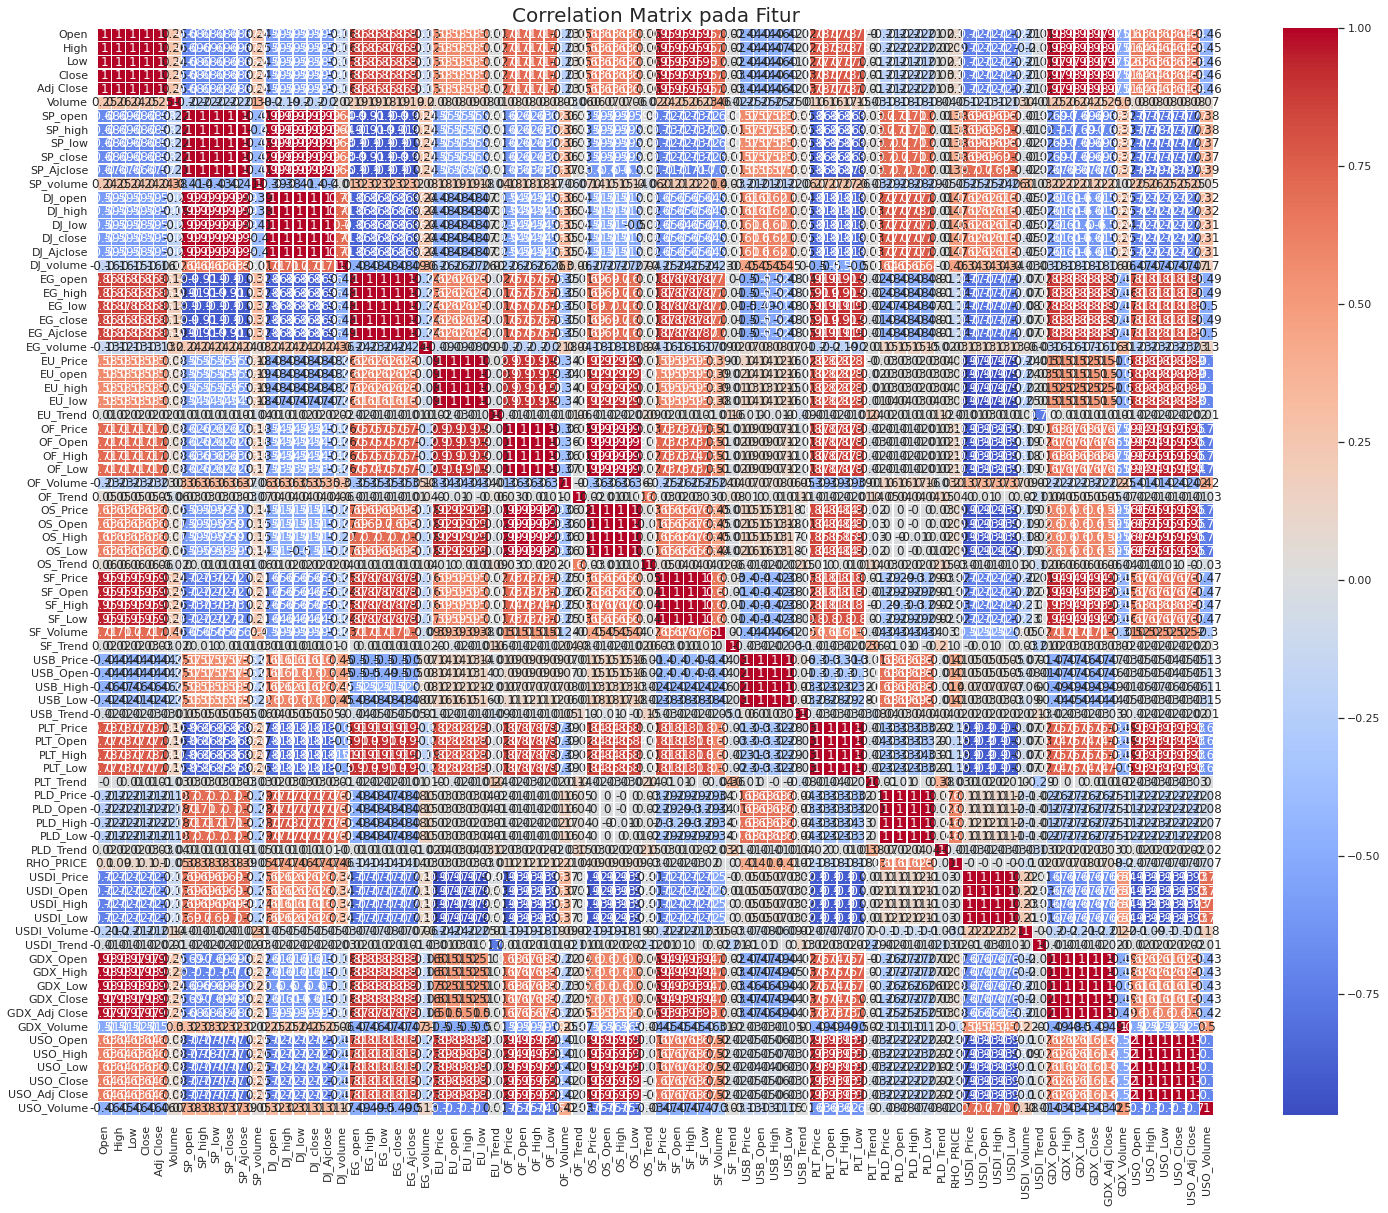

In [29]:
plt.figure(figsize=(25,20))
correlation_matrix = gold_df.corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix pada Fitur", size=20)

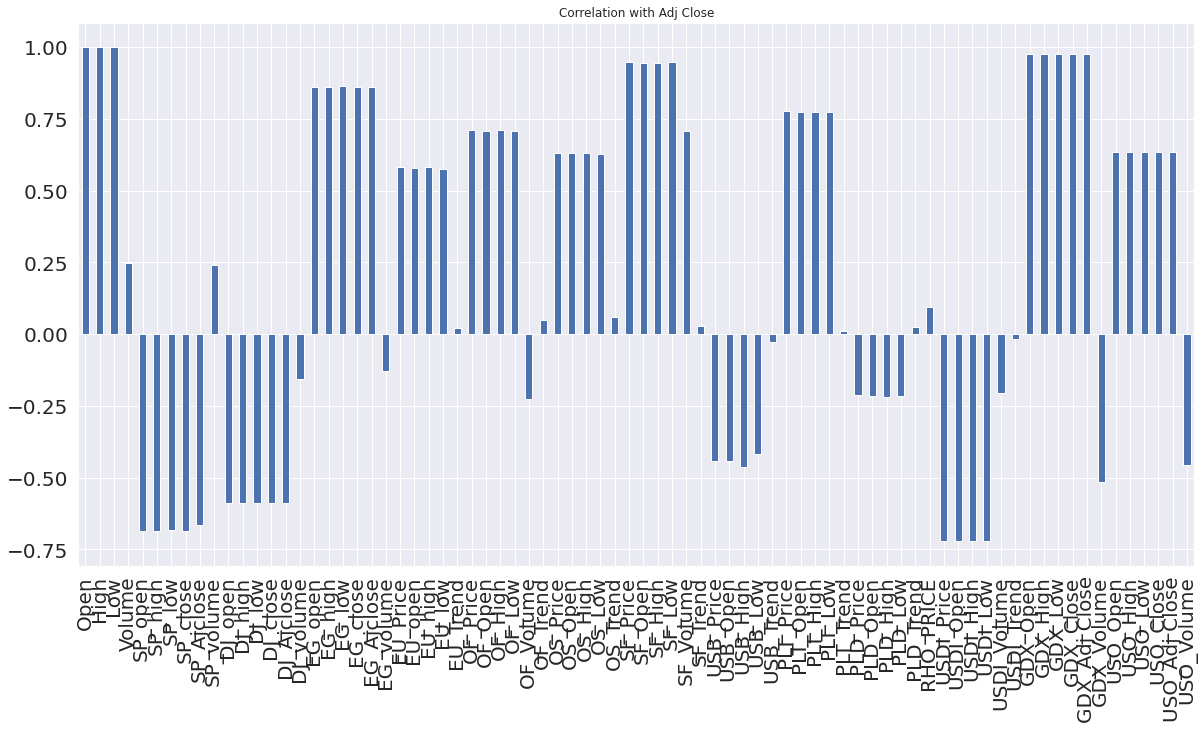

In [30]:
X.corrwith(y).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True)

# Data Preparation

## Feature selection

Analisa fitur apa saja yang mempengaruhi hasil target dengan mutual_info_regression

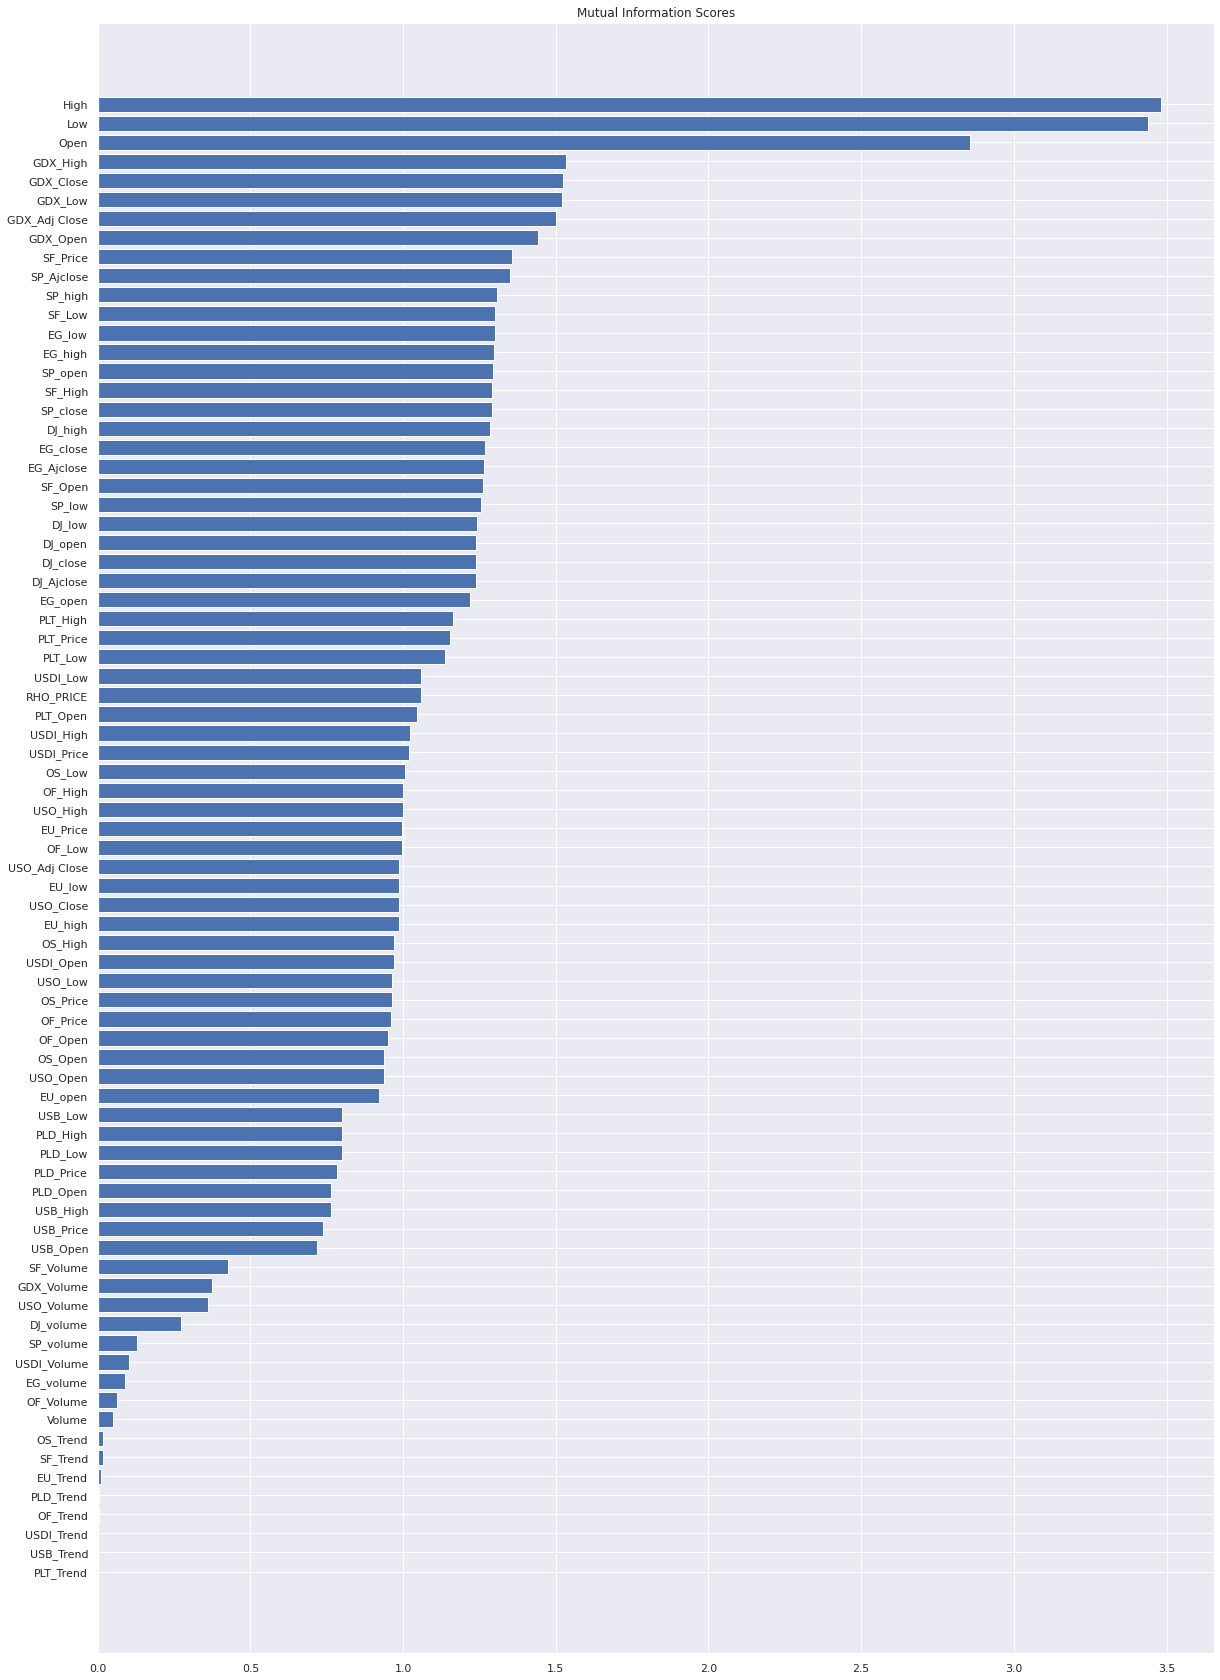

In [31]:
# create mutual info score

def mutual_info_scores(X, y):
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, name="Mutual Info Score", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=True)

  return mi_scores

def plot_mi_scores(scores):
  score = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.figure(figsize=(20,30))
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

mi_scores = mutual_info_scores(X, y)
plot_mi_scores(mi_scores)

setelah diurutkan, maka akan tampak fitur-fitur yang paling berpengaruh dengan target. kemudian ambil 10 fitur dengan mutual info score tertinggi untuk dijadikan data.

In [32]:
mi_scores = mi_scores.sort_values(ascending=False)
selected_features = mi_scores.index[:10].to_list()
X = X[selected_features]
X.head()

,High,Low,Open,GDX_High,GDX_Close,GDX_Low,GDX_Adj Close,GDX_Open,SF_Price,SP_Ajclose
0,154.949997,151.710007,154.740005,53.139999,51.680000,51.570000,48.973877,53.009998,53604,105.441238
1,155.369995,153.899994,154.309998,53.180000,52.680000,52.040001,49.921513,52.500000,53458,105.597549
2,155.860001,154.360001,155.479996,52.549999,51.169998,51.029999,48.490578,52.490002,52961,104.468536
3,157.429993,156.580002,156.820007,53.250000,52.990002,52.369999,50.215282,52.380001,53487,107.629784
4,157.529999,156.130005,156.979996,53.430000,52.959999,52.419998,50.186852,53.150002,53148,107.838242


## Train test split

membagi data menjadi data training dan testing dengan rasio 80%:20%

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 
print(f'Total sample in whole dataset: {len(X)}')
print(f'Total sample in train dataset: {len(X_train)}')
print(f'Total sample in test dataset: {len(X_test)}')

Total sample in whole dataset: 1718
Total sample in train dataset: 1374
Total sample in test dataset: 344


## Standarisasi

Algoritma machine learning memiliki performa lebih baik dan konvergen lebih cepat ketika dimodelkan pada data dengan skala relatif sama atau mendekati distribusi normal. Proses scaling dan standarisasi membantu untuk membuat fitur data menjadi bentuk yang lebih mudah diolah oleh algoritma.

StandardScaler melakukan proses standarisasi fitur dengan z-score, yaitu mengurangkan mean (nilai rata-rata) kemudian membaginya dengan standar deviasi untuk menggeser distribusi. StandardScaler menghasilkan distribusi dengan standar deviasi sama dengan 1 dan mean sama dengan 0.

In [34]:
# z-score standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.head()

,High,Low,Open,GDX_High,GDX_Close,GDX_Low,GDX_Adj Close,GDX_Open,SF_Price,SP_Ajclose
0,1.323264,1.229629,1.349120,2.139205,2.064801,2.107311,2.043402,2.174061,1.147190,-1.947912
1,1.345127,1.345008,1.326618,2.142659,2.151896,2.148639,2.131620,2.129708,1.128952,-1.943470
2,1.370635,1.369243,1.387842,2.088252,2.020383,2.059828,1.998410,2.128839,1.066870,-1.975553
3,1.452360,1.486204,1.457962,2.148705,2.178895,2.177656,2.158968,2.119273,1.132575,-1.885719
4,1.457566,1.462496,1.466334,2.164250,2.176282,2.182053,2.156322,2.186236,1.090229,-1.879796


## Dimension reduction dengan PCA

In [35]:
# dimension reduction
pca = PCA().fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, columns=selected_features)

X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca, columns=selected_features)

X_train_pca.head()

,High,Low,Open,GDX_High,GDX_Close,GDX_Low,GDX_Adj Close,GDX_Open,SF_Price,SP_Ajclose
0,5.531299,-0.193513,1.162867,-0.611195,-0.116946,0.055249,0.021203,-0.010306,0.009602,-0.004984
1,5.618002,-0.160694,1.194995,-0.575517,0.008186,-0.022151,-0.010786,-0.001072,0.003122,-0.002738
2,5.511475,-0.257298,1.133984,-0.438793,-0.099825,-0.000445,-0.023647,0.015245,-0.006540,-0.002546
3,5.751457,-0.094589,1.130979,-0.412797,0.033317,-0.049131,-0.000273,0.003106,0.019013,-0.004474
4,5.759739,-0.078357,1.183857,-0.404117,-0.019694,-0.025324,0.004568,0.002142,-0.005341,0.002493


# Model Development

## Linear regression

In [36]:
# linear regression

linreg_model = LinearRegression()
linreg_model.fit(X_train_pca, y_train)
linreg_pred = linreg_model.predict(X_test_pca)

linreg_df = pd.DataFrame({'y_true': y_test,
                          'y_pred': linreg_pred})

linreg_mse = mean_squared_error(y_test, linreg_pred)
linreg_mae = mean_absolute_error(y_test, linreg_pred)

linreg_df.head()

,y_true,y_pred
1374,122.790001,122.555676
1375,121.919998,121.932323
1376,121.870003,121.788951
1377,122.489998,122.071507
1378,122.300003,122.331320


## Random forest regression

In [37]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=16,
                                 random_state=55, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)
rf_pred = rf_model.predict(X_test_pca)

rf_df = pd.DataFrame({'y_true': y_test,
                          'y_pred': rf_pred})

rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

rf_df.head()

,y_true,y_pred
1374,122.790001,121.692599
1375,121.919998,121.034400
1376,121.870003,120.791551
1377,122.489998,121.217080
1378,122.300003,121.033280


## Gradient booster

In [38]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train_pca, y_train)
xgb_pred = xgb_model.predict(X_test_pca)

xgb_df = pd.DataFrame({'y_true': y_test,
                          'y_pred': xgb_pred})

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

xgb_df.head()

[12:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,y_true,y_pred
1374,122.790001,121.415825
1375,121.919998,121.066544
1376,121.870003,120.987541
1377,122.489998,121.083138
1378,122.300003,121.124069


# Model Evaluation

mengevaluasi model dengan Mean Squared Error (MSE) dan Mean Absolute Error (MAE) dari hasil prediksi data testing.

Dapat disimpulkan bahwa model Linear Regression mendapatkan nilai error paling kecil dari MSE dan MAE nya.

In [39]:
metrics_df = pd.DataFrame({'MSE': [linreg_mse, rf_mse, xgb_mse],
                           'MAE': [linreg_mae, rf_mae, xgb_mae]},
                          index=['Linear Regression', 'Random Forest', 'Gradient Booster'])
metrics_df

,MSE,MAE
Linear Regression,0.029676,0.136034
Random Forest,13.043190,3.224654
Gradient Booster,9.766769,2.583259


melakukan plotting hasil prediksi dan hasil aktual. dapat disimpulkan bahwa model bekerja cukup baik

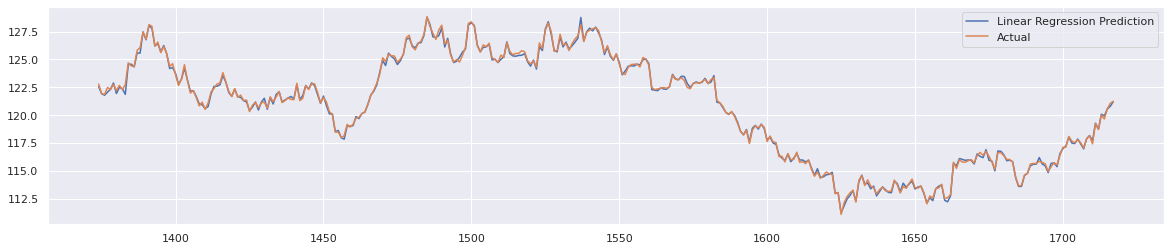

In [40]:
data = pd.DataFrame({'Linear Regression Prediction': linreg_pred,
                     'Actual': y_test})
data.plot()